<a href="https://colab.research.google.com/github/YunfengGe0805/AIDclassification/blob/main/finalML_CNN_AID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is not a pretrained CNN(not run)

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from PIL import Image
from sklearn.metrics import accuracy_score
class ClsDataset(data_utils.Dataset):
    def __init__(self,root_path,data_list_file,img_size=600):
        self.file_names=np.loadtxt(data_list_file,dtype=np.str_,usecols=0)
        self.labels=np.loadtxt(data_list_file,dtype=np.int64,usecols=1)
        self.root_path=root_path

        self.transforms=torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size,img_size)),
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self,item):
        file_name=self.file_names[item]
        data_file=os.path.join(self.root_path,file_name)
        img=Image.open(data_file)
        label=self.labels[item]
        img=self.transforms(img)
        label=torch.tensor(label)
        return img,label

    def __len__(self):
      return len(self.file_names)

class ClsNet(nn.Module):
    def __init__(self,num_classes=30):
        super(ClsNet,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3,32,3,1,padding=1),
            nn.ReLU())
        self.pool1=nn.AvgPool2d(2,2)
        self.conv2=nn.Sequential(
            nn.Conv2d(32,64,3,1,padding=1),
            nn.ReLU())
        self.pool2=nn.AvgPool2d(2, 2)
        self.conv3=nn.Sequential(
            nn.Conv2d(64,128,3,1,padding=1),
            nn.ReLU())
        self.pool3=nn.AvgPool2d(2,2)
        self.conv4=nn.Sequential(
            nn.Conv2d(128,256,3,1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.pool4=nn.AvgPool2d(2,2)
        self.conv5=nn.Sequential(
            nn.Conv2d(256,512,3,1,padding=1)
        )
        self.pool5=nn.AvgPool2d(2,2)
        self.pred_fc=nn.Sequential(
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,num_classes))
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.softmax=nn.Softmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool5(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.avg_pool(x)
        x = torch.flatten(x,1)
        logits=self.pred_fc(x)
        prob=self.softmax(logits)
        return logits,prob

if __name__ == '__main__':
    device = 'cuda'
    #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ClsNet()
    model.to(device)

    train_dataset = ClsDataset(
        r'/content/drive/MyDrive/AID/data',
        r'/content/drive/MyDrive/AID/train_data_list.txt'
    )
    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

    valid_dataset = ClsDataset(
        r'/content/drive/MyDrive/AID/data',
        r'/content/drive/MyDrive/AID/val_data_list.txt'
    )
    valid_dataloader = data_utils.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    best_acc = 0
    num_epochs = 50

    # Lists to store losses
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for data in train_dataloader:
            train_img, train_label = data
            train_img = train_img.to(device)
            train_label = train_label.to(device)
            train_logits,train_prob = model(train_img)
            train_loss = criterion(train_logits, train_label)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()

        epoch_train_loss /= len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        epoch_valid_loss = 0
        label_list = []
        pred_list = []
        with torch.no_grad():
            for data in valid_dataloader:
                valid_img, valid_label = data
                valid_img = valid_img.to(device)
                valid_label = valid_label.to(device)

                valid_logits,valid_prob = model(valid_img)
                valid_loss = criterion(valid_logits, valid_label)
                epoch_valid_loss += valid_loss.item()

                valid_pred = torch.argmax(valid_prob, dim=1)
                label_list.append(valid_label.cpu().numpy())
                pred_list.append(valid_pred.cpu().numpy())

        epoch_valid_loss /= len(valid_dataloader)
        valid_losses.append(epoch_valid_loss)

        # Validation accuracy
        if label_list and pred_list:  # Ensure lists are not empty
            label_list = np.concatenate(label_list)
            pred_list = np.concatenate(pred_list)
            valid_acc = accuracy_score(label_list, pred_list)
            print(f'Epoch: {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
                  f'Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {valid_acc:.4f}')

            if valid_acc > best_acc:
                best_acc = valid_acc
                state_dict = model.state_dict()
                torch.save(state_dict, r'/content/drive/MyDrive/AID/CNN_nores_best.pth')

    # Plotting the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


KeyboardInterrupt: 

Model Evaluation

In [ ]:
import numpy as np
import torch
import torch.utils.data as data_utils
from sklearn.metrics import accuracy_score
#from ResNet50_loss import ClsDataset, ClsNet
import os
import torch.nn as nn
import torchvision
from PIL import Image
class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=600):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path

        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size, img_size)),
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file).convert('RGB')  # Ensure image is in RGB mode
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)

class ClsNet(nn.Module):
    def __init__(self,num_classes=30):
        super(ClsNet,self).__init__()
        self.conv1=nn.Sequential(
            nn.Cov2d(3,32,3,1,padding=1),
            nn.ReLU())
        self.pool1=nn.AvgPool2d(2,2)
        self.conv2=nn.Sequential(
            nn.Conv2d(32,64,3,1,padding=1),
            nn.ReLU())
        self.pool2=nn.AvgPool2d(2, 2)
        self.conv3=nn.Sequential(
            nn.Conv2d(64,128,3,1,padding=1),
            nn.ReLU())
        self.pool3=nn.AvgPool2d(2,2)
        self.conv4=nn.Sequential(
            nn.Conv2d(128,256,3,1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.pool5=nn.AvgPool2d(2,2)
        self.pred_fc=nn.Sequential(
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,num_classes))
        self.avg_pool-nn.AdaptiveAvgPool2d((1,1))
        self.softmax=nn.Softmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.avg_pool(x)
        x = torch.flatten(x,1)
        logits=self.pred_fc(x)
        prob=self.softmax(logits)
        return logits,prob




model = ClsNet(num_classes=30)
model.load_state_dict(torch.load(r'/content/drive/MyDrive/AID/CNN_nores_best.pth'))
model.eval()
device = 'cuda'
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_dataset = ClsDataset(
    root_path=r'/content/drive/MyDrive/AID/data',
    data_list_file=r'/content/drive/MyDrive/AID/test_data_list.txt'
)
test_dataloader = data_utils.DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=2
)

if __name__ == '__main__':
    label_list = []
    pred_list = []
    for data in test_dataloader:
        test_img, test_label = data
        test_img = test_img.to(device)
        test_label = test_label.to(device)

        test_logits, test_prob = model(test_img)
        test_pred = torch.argmax(test_prob, dim=1)

        label_list.append(test_label.cpu().numpy())
        pred_list.append(test_pred.cpu().numpy())

    label_list = np.concatenate(label_list)
    pred_list = np.concatenate(pred_list)
    test_acc = accuracy_score(label_list, pred_list)
    print('test_acc:%g' % test_acc)


Optuna hyperparameter tune

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from PIL import Image
from sklearn.metrics import accuracy_score
import optuna
import matplotlib.pyplot as plt


class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=600):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path

        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size, img_size)),
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file).convert('RGB')  # Ensure image is in RGB mode
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


class ClsNet(nn.Module):
    def __init__(self, num_classes=30):
        super(ClsNet, self).__init__()
        self.resnet50 = torchvision.models.resnet50(weights='DEFAULT')
        self.pred_fc = nn.Linear(2048, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)
        x = self.resnet50.layer1(x)
        x = self.resnet50.layer2(x)
        x = self.resnet50.layer3(x)
        x = self.resnet50.layer4(x)
        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.pred_fc(x)
        prob = self.softmax(logits)
        return logits, prob


def objective(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters to tune
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    num_epochs = 10  # Reduced for faster optimization

    # Data loaders
    train_dataset = ClsDataset(
        r'/kaggle/input/aid-cnn/AID\data',
        r'/kaggle/input/aid-cnn/AID\train_data_list.txt'
    )
    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    valid_dataset = ClsDataset(
        r'/kaggle/input/aid-cnn/AID\data',
        r'/kaggle/input/aid-cnn/AID\val_data_list.txt'
    )
    valid_dataloader = data_utils.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Model, loss, and optimizer
    model = ClsNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_valid_acc = 0
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for data in train_dataloader:
            train_img, train_label = data
            train_img, train_label = train_img.to(device), train_label.to(device)
            train_logits, train_prob = model(train_img)
            train_loss = criterion(train_logits, train_label)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        label_list = []
        pred_list = []
        with torch.no_grad():
            for data in valid_dataloader:
                valid_img, valid_label = data
                valid_img, valid_label = valid_img.to(device), valid_label.to(device)
                valid_logits, valid_prob = model(valid_img)

                valid_pred = torch.argmax(valid_prob, dim=1)
                label_list.append(valid_label.cpu().numpy())
                pred_list.append(valid_pred.cpu().numpy())

        if label_list and pred_list:  # Ensure lists are not empty
            label_list = np.concatenate(label_list)
            pred_list = np.concatenate(pred_list)
            valid_acc = accuracy_score(label_list, pred_list)

            # Track the best accuracy
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc

    return best_valid_acc


if __name__ == '__main__':
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    print("Best hyperparameters:", study.best_params)
    print("Best validation accuracy:", study.best_value)


ResNet50 adding loss curve revised

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


Epoch: 1/50, Train Loss: 3.0183, Valid Loss: 2.5479, Valid Accuracy: 0.2295
Epoch: 2/50, Train Loss: 2.4200, Valid Loss: 2.3666, Valid Accuracy: 0.3010
Epoch: 3/50, Train Loss: 2.2162, Valid Loss: 2.5841, Valid Accuracy: 0.3585
Epoch: 4/50, Train Loss: 2.0059, Valid Loss: 2.5369, Valid Accuracy: 0.2670
Epoch: 5/50, Train Loss: 1.7360, Valid Loss: 2.2760, Valid Accuracy: 0.4360
Epoch: 6/50, Train Loss: 1.5492, Valid Loss: 1.8527, Valid Accuracy: 0.5420
Epoch: 7/50, Train Loss: 1.3965, Valid Loss: 1.4500, Valid Accuracy: 0.6020
Epoch: 8/50, Train Loss: 1.3260, Valid Loss: 1.3927, Valid Accuracy: 0.6410
Epoch: 9/50, Train Loss: 1.2172, Valid Loss: 1.5675, Valid Accuracy: 0.5660
Epoch: 10/50, Train Loss: 1.1441, Valid Loss: 1.3084, Valid Accuracy: 0.6215
Epoch: 11/50, Train Loss: 1.0987, Valid Loss: 1.3673, Valid Accuracy: 0.6350
Epoch: 12/50, Train Loss: 1.0068, Valid Loss: 2.1307, Valid Accuracy: 0.5725
Epoch: 13/50, Train Loss: 0.9474, Valid Loss: 1.3679, Valid Accuracy: 0.6010
Epoch: 1

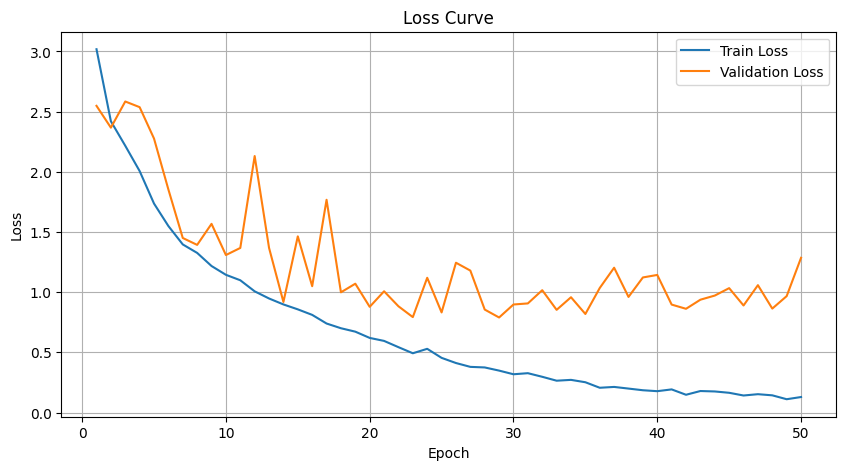

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score


class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=600):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path

        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size, img_size)),
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file).convert('RGB')  # Ensure image is in RGB mode
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


class ClsNet(nn.Module):
    def __init__(self, num_classes=30):
        super(ClsNet, self).__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        self.pred_fc = nn.Linear(2048, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)
        x = self.resnet50.layer1(x)
        x = self.resnet50.layer2(x)
        x = self.resnet50.layer3(x)
        x = self.resnet50.layer4(x)
        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.pred_fc(x)
        prob = self.softmax(logits)
        return logits, prob


if __name__ == '__main__':
    device = 'cuda'
    #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ClsNet()
    model.to(device)

    train_dataset = ClsDataset(
        r'/content/drive/MyDrive/AID/data',
        r'/content/drive/MyDrive/AID/train_data_list.txt'
    )
    train_dataloader = data_utils.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

    valid_dataset = ClsDataset(
        r'/content/drive/MyDrive/AID/data',
        r'/content/drive/MyDrive/AID/val_data_list.txt'
    )
    valid_dataloader = data_utils.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    best_acc = 0
    num_epochs = 50

    # Lists to store losses
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for data in train_dataloader:
            train_img, train_label = data
            train_img = train_img.to(device)
            train_label = train_label.to(device)
            train_logits,train_prob = model(train_img)
            train_loss = criterion(train_logits, train_label)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()

        epoch_train_loss /= len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        epoch_valid_loss = 0
        label_list = []
        pred_list = []
        with torch.no_grad():
            for data in valid_dataloader:
                valid_img, valid_label = data
                valid_img = valid_img.to(device)
                valid_label = valid_label.to(device)

                valid_logits,valid_prob = model(valid_img)
                valid_loss = criterion(valid_logits, valid_label)
                epoch_valid_loss += valid_loss.item()

                valid_pred = torch.argmax(valid_prob, dim=1)
                label_list.append(valid_label.cpu().numpy())
                pred_list.append(valid_pred.cpu().numpy())

        epoch_valid_loss /= len(valid_dataloader)
        valid_losses.append(epoch_valid_loss)

        # Validation accuracy
        if label_list and pred_list:  # Ensure lists are not empty
            label_list = np.concatenate(label_list)
            pred_list = np.concatenate(pred_list)
            valid_acc = accuracy_score(label_list, pred_list)
            print(f'Epoch: {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
                  f'Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {valid_acc:.4f}')

            if valid_acc > best_acc:
                best_acc = valid_acc
                state_dict = model.state_dict()
                torch.save(state_dict, r'/content/drive/MyDrive/AID/CNN_best.pth')

    # Plotting the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

Best Model Validation

In [ ]:
import numpy as np
import torch
import torch.utils.data as data_utils
from sklearn.metrics import accuracy_score
#from ResNet50_loss import ClsDataset, ClsNet
import os
import torch.nn as nn
import torchvision
from PIL import Image
class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=600):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path

        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size, img_size)),
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file).convert('RGB')  # Ensure image is in RGB mode
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


class ClsNet(nn.Module):
    def __init__(self, num_classes=30):
        super(ClsNet, self).__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        self.pred_fc = nn.Linear(2048, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.resnet50.conv1(x)
        x = self.resnet50.bn1(x)
        x = self.resnet50.relu(x)
        x = self.resnet50.maxpool(x)
        x = self.resnet50.layer1(x)
        x = self.resnet50.layer2(x)
        x = self.resnet50.layer3(x)
        x = self.resnet50.layer4(x)
        x = self.resnet50.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.pred_fc(x)
        prob = self.softmax(logits)
        return logits, prob


model = ClsNet(num_classes=30)
model.load_state_dict(torch.load(r'/content/drive/MyDrive/AID/CNN_best.pth'))
model.eval()
device = 'cuda'
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_dataset = ClsDataset(
    root_path=r'/content/drive/MyDrive/AID/data',
    data_list_file=r'/content/drive/MyDrive/AID/test_data_list.txt'
)
test_dataloader = data_utils.DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=2
)

if __name__ == '__main__':
    label_list = []
    pred_list = []
    for data in test_dataloader:
        test_img, test_label = data
        test_img = test_img.to(device)
        test_label = test_label.to(device)

        test_logits, test_prob = model(test_img)
        test_pred = torch.argmax(test_prob, dim=1)

        label_list.append(test_label.cpu().numpy())
        pred_list.append(test_pred.cpu().numpy())

    label_list = np.concatenate(label_list)
    pred_list = np.concatenate(pred_list)
    test_acc = accuracy_score(label_list, pred_list)
    print('test_acc:%g' % test_acc)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]
<ipython-input-1-b3804749fc79>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possi

test_acc:0.809335


Revised should have a higher speed
Code Optimization
Efficient Data Loading and Preprocessing:

Increase the num_workers in the DataLoader to use more CPU threads for data loading. Set it to os.cpu_count() for optimal performance.
Use torchvision.transforms for efficient augmentations and apply caching mechanisms if possible.
Reduce Image Size:

Reduce the image size (e.g., to 224x224) to lower computational cost without significantly impacting accuracy.
Avoid Explicit Softmax:

Remove self.softmax from ClsNet. Use CrossEntropyLoss, which implicitly applies softmax.
Mixed Precision Training:

Use torch.cuda.amp for mixed precision training to reduce memory usage and computation time.
Optimized Model Structure:

Use torchvision.models.resnet50 directly without manually passing data through the layers. Replace avgpool with AdaptiveAvgPool2d for dynamic handling.
Efficient Logging:

Print logs conditionally (e.g., every 5 epochs) to reduce I/O overhead.
Optimizer Scheduler:

Add a learning rate scheduler for better convergence.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]
<ipython-input-1-910a454ae772>:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipyth

Epoch 1/50, Train Loss: 0.7432, Valid Loss: 0.2818, Valid Accuracy: 0.9170


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/50, Train Loss: 0.2058, Valid Loss: 0.2843, Valid Accuracy: 0.9110


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/50, Train Loss: 0.1213, Valid Loss: 0.2340, Valid Accuracy: 0.9290


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/50, Train Loss: 0.0791, Valid Loss: 0.2019, Valid Accuracy: 0.9350


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/50, Train Loss: 0.0724, Valid Loss: 0.2288, Valid Accuracy: 0.9375


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/50, Train Loss: 0.0650, Valid Loss: 0.2484, Valid Accuracy: 0.9315


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/50, Train Loss: 0.0621, Valid Loss: 0.2243, Valid Accuracy: 0.9395


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/50, Train Loss: 0.0233, Valid Loss: 0.1392, Valid Accuracy: 0.9615


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/50, Train Loss: 0.0108, Valid Loss: 0.1395, Valid Accuracy: 0.9560


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/50, Train Loss: 0.0103, Valid Loss: 0.1299, Valid Accuracy: 0.9640


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11/50, Train Loss: 0.0087, Valid Loss: 0.1395, Valid Accuracy: 0.9590


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12/50, Train Loss: 0.0068, Valid Loss: 0.1239, Valid Accuracy: 0.9635


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13/50, Train Loss: 0.0051, Valid Loss: 0.1288, Valid Accuracy: 0.9635


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14/50, Train Loss: 0.0069, Valid Loss: 0.1367, Valid Accuracy: 0.9625


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15/50, Train Loss: 0.0029, Valid Loss: 0.1303, Valid Accuracy: 0.9610


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16/50, Train Loss: 0.0022, Valid Loss: 0.1293, Valid Accuracy: 0.9645


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17/50, Train Loss: 0.0021, Valid Loss: 0.1285, Valid Accuracy: 0.9640


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18/50, Train Loss: 0.0035, Valid Loss: 0.1316, Valid Accuracy: 0.9665


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19/50, Train Loss: 0.0024, Valid Loss: 0.1308, Valid Accuracy: 0.9670


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20/50, Train Loss: 0.0030, Valid Loss: 0.1347, Valid Accuracy: 0.9680


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21/50, Train Loss: 0.0016, Valid Loss: 0.1322, Valid Accuracy: 0.9625


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22/50, Train Loss: 0.0014, Valid Loss: 0.1242, Valid Accuracy: 0.9665


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23/50, Train Loss: 0.0014, Valid Loss: 0.1205, Valid Accuracy: 0.9675


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24/50, Train Loss: 0.0018, Valid Loss: 0.1272, Valid Accuracy: 0.9675


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25/50, Train Loss: 0.0010, Valid Loss: 0.1312, Valid Accuracy: 0.9665


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 26/50, Train Loss: 0.0010, Valid Loss: 0.1294, Valid Accuracy: 0.9655


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 27/50, Train Loss: 0.0007, Valid Loss: 0.1269, Valid Accuracy: 0.9655


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 28/50, Train Loss: 0.0005, Valid Loss: 0.1236, Valid Accuracy: 0.9680


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 29/50, Train Loss: 0.0005, Valid Loss: 0.1268, Valid Accuracy: 0.9675


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 30/50, Train Loss: 0.0005, Valid Loss: 0.1372, Valid Accuracy: 0.9650


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 31/50, Train Loss: 0.0006, Valid Loss: 0.1322, Valid Accuracy: 0.9660


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 32/50, Train Loss: 0.0008, Valid Loss: 0.1262, Valid Accuracy: 0.9670


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 33/50, Train Loss: 0.0004, Valid Loss: 0.1343, Valid Accuracy: 0.9670


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 34/50, Train Loss: 0.0004, Valid Loss: 0.1308, Valid Accuracy: 0.9665


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 35/50, Train Loss: 0.0009, Valid Loss: 0.1315, Valid Accuracy: 0.9660


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 36/50, Train Loss: 0.0011, Valid Loss: 0.1250, Valid Accuracy: 0.9685


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 37/50, Train Loss: 0.0003, Valid Loss: 0.1229, Valid Accuracy: 0.9670


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 38/50, Train Loss: 0.0007, Valid Loss: 0.1286, Valid Accuracy: 0.9665


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 39/50, Train Loss: 0.0005, Valid Loss: 0.1181, Valid Accuracy: 0.9705


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 40/50, Train Loss: 0.0006, Valid Loss: 0.1225, Valid Accuracy: 0.9715


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 41/50, Train Loss: 0.0005, Valid Loss: 0.1210, Valid Accuracy: 0.9700


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 42/50, Train Loss: 0.0003, Valid Loss: 0.1198, Valid Accuracy: 0.9720


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 43/50, Train Loss: 0.0004, Valid Loss: 0.1265, Valid Accuracy: 0.9680


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 44/50, Train Loss: 0.0003, Valid Loss: 0.1195, Valid Accuracy: 0.9700


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 45/50, Train Loss: 0.0003, Valid Loss: 0.1300, Valid Accuracy: 0.9670


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 46/50, Train Loss: 0.0003, Valid Loss: 0.1216, Valid Accuracy: 0.9680


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 47/50, Train Loss: 0.0004, Valid Loss: 0.1206, Valid Accuracy: 0.9700


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 48/50, Train Loss: 0.0003, Valid Loss: 0.1243, Valid Accuracy: 0.9655


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 49/50, Train Loss: 0.0004, Valid Loss: 0.1308, Valid Accuracy: 0.9680


<ipython-input-1-910a454ae772>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training
<ipython-input-1-910a454ae772>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 50/50, Train Loss: 0.0004, Valid Loss: 0.1277, Valid Accuracy: 0.9665


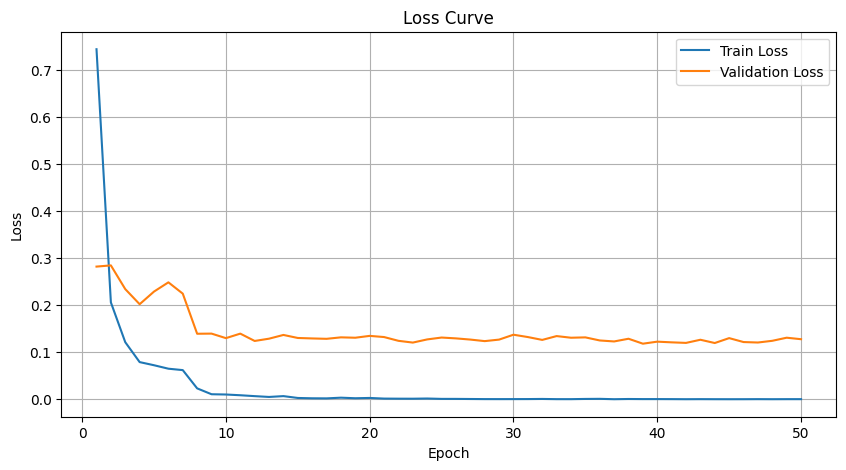

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler

# Dataset class remains the same with a smaller img_size for better performance
class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path
        self.transforms = Compose([Resize((img_size, img_size)), ToTensor()])

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file).convert('RGB')
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)

# Optimized ClsNet class
class ClsNet(nn.Module):
    def __init__(self, num_classes=30):
        super(ClsNet, self).__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ClsNet(num_classes=30).to(device)

    train_dataset = ClsDataset(
        root_path='/content/drive/MyDrive/AID/data',
        data_list_file='/content/drive/MyDrive/AID/train_data_list.txt',
    )
    valid_dataset = ClsDataset(
        root_path='/content/drive/MyDrive/AID/data',
        data_list_file='/content/drive/MyDrive/AID/val_data_list.txt',
    )

    train_dataloader = data_utils.DataLoader(
        train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count()
    )
    valid_dataloader = data_utils.DataLoader(
        valid_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count()
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.000116358642683977)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.511150632559831)
    scaler = GradScaler()

    best_acc = 0
    num_epochs = 50

    train_losses, valid_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for train_img, train_label in train_dataloader:
            train_img, train_label = train_img.to(device), train_label.to(device)
            optimizer.zero_grad()

            with autocast():  # Mixed precision training
                train_logits = model(train_img)
                train_loss = criterion(train_logits, train_label)

            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss += train_loss.item()

        epoch_train_loss /= len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        epoch_valid_loss = 0
        label_list, pred_list = [], []
        with torch.no_grad():
            for valid_img, valid_label in valid_dataloader:
                valid_img, valid_label = valid_img.to(device), valid_label.to(device)
                with autocast():
                    valid_logits = model(valid_img)
                    valid_loss = criterion(valid_logits, valid_label)

                epoch_valid_loss += valid_loss.item()
                valid_pred = torch.argmax(valid_logits, dim=1)
                label_list.append(valid_label.cpu().numpy())
                pred_list.append(valid_pred.cpu().numpy())

        epoch_valid_loss /= len(valid_dataloader)
        valid_losses.append(epoch_valid_loss)

        # Calculate accuracy
        label_list = np.concatenate(label_list)
        pred_list = np.concatenate(pred_list)
        valid_acc = accuracy_score(label_list, pred_list)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
              f'Valid Loss: {epoch_valid_loss:.4f}, Valid Accuracy: {valid_acc:.4f}')

        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/AID/ResNet50_best_optuna.pth')

        scheduler.step()

    # Plotting the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


Model Evaluation with complete matrix

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-2-701291d4f0ff>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Test Accuracy: 0.9702
Test Precision: 0.9703
Test Recall: 0.9702
Test F1 Score: 0.9701


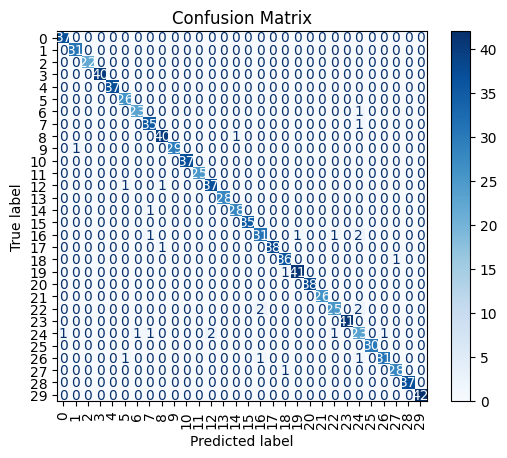

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Dataset class
class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path
        self.transforms = Compose([Resize((img_size, img_size)), ToTensor()])

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file).convert('RGB')
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


# Optimized ClsNet class
class ClsNet(nn.Module):
    def __init__(self, num_classes=30):
        super(ClsNet, self).__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        # Replace the last fully connected layer for 30 classes
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)


if __name__ == '__main__':
    # Load the model architecture
    model = ClsNet(num_classes=30)

    # Load the checkpoint
    checkpoint_path = r'/content/drive/MyDrive/AID/ResNet50_best_optuna.pth'
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Prepare the test dataset and dataloader
    test_dataset = ClsDataset(
        root_path=r'/content/drive/MyDrive/AID/data',
        data_list_file=r'/content/drive/MyDrive/AID/test_data_list.txt',
    )
    test_dataloader = data_utils.DataLoader(
        test_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count()
    )

    # Initialize metrics tracking
    label_list = []
    pred_list = []

    # Inference loop
    for data in test_dataloader:
        test_img, test_label = data
        test_img = test_img.to(device)
        test_label = test_label.to(device)

        # Forward pass
        with torch.no_grad():
            test_logits = model(test_img)
            test_pred = torch.argmax(test_logits, dim=1)

        # Append results for evaluation
        label_list.append(test_label.cpu().numpy())
        pred_list.append(test_pred.cpu().numpy())

    # Concatenate all predictions and labels
    label_list = np.concatenate(label_list)
    pred_list = np.concatenate(pred_list)

    # Calculate metrics
    test_acc = accuracy_score(label_list, pred_list)
    test_precision = precision_score(label_list, pred_list, average='weighted')
    test_recall = recall_score(label_list, pred_list, average='weighted')
    test_f1 = f1_score(label_list, pred_list, average='weighted')

    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')

    # Generate and display the confusion matrix
    cm = confusion_matrix(label_list, pred_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_list))
    disp.plot(cmap='Blues', xticks_rotation='vertical')

    plt.title('Confusion Matrix')
    plt.show()


Optuna Tuning for the 224 one

In [ ]:
%pip install optuna

import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast, GradScaler
import optuna
from optuna.trial import TrialState

# Dataset and ClsNet classes remain the same

class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path
        self.transforms = Compose([Resize((img_size, img_size)), ToTensor()])

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file).convert('RGB')
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)

class ClsNet(nn.Module):
    def __init__(self, num_classes=30):
        super(ClsNet, self).__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

def train_and_evaluate(trial):
    # Hyperparameter suggestions from Optuna
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    step_size = trial.suggest_int('step_size', 5, 20)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = ClsNet(num_classes=30).to(device)

    # Data loaders
    train_dataset = ClsDataset(
        root_path='/content/drive/MyDrive/AID/data',
        data_list_file='/content/drive/MyDrive/AID/train_data_list.txt',
    )
    valid_dataset = ClsDataset(
        root_path='/content/drive/MyDrive/AID/data',
        data_list_file='/content/drive/MyDrive/AID/val_data_list.txt',
    )

    train_dataloader = data_utils.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()
    )
    valid_dataloader = data_utils.DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count()
    )

    # Loss, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    scaler = GradScaler()

    num_epochs = 10  # Keep this low for faster tuning
    best_valid_acc = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for train_img, train_label in train_dataloader:
            train_img, train_label = train_img.to(device), train_label.to(device)
            optimizer.zero_grad()

            with autocast():
                train_logits = model(train_img)
                train_loss = criterion(train_logits, train_label)

            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Validation phase
        model.eval()
        label_list, pred_list = [], []
        with torch.no_grad():
            for valid_img, valid_label in valid_dataloader:
                valid_img, valid_label = valid_img.to(device), valid_label.to(device)
                with autocast():
                    valid_logits = model(valid_img)
                valid_pred = torch.argmax(valid_logits, dim=1)
                label_list.append(valid_label.cpu().numpy())
                pred_list.append(valid_pred.cpu().numpy())

        # Calculate accuracy
        label_list = np.concatenate(label_list)
        pred_list = np.concatenate(pred_list)
        valid_acc = accuracy_score(label_list, pred_list)

        # Save the best accuracy for Optuna
        best_valid_acc = max(best_valid_acc, valid_acc)

        scheduler.step()

    return best_valid_acc

if __name__ == '__main__':
    # Optuna study setup
    study = optuna.create_study(direction='maximize')
    study.optimize(train_and_evaluate, n_trials=20)  # Run 20 trials

    # Print the best trial
    print("Best trial:")
    trial = study.best_trial

    print(f"  Accuracy: {trial.value}")
    print("  Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2024-11-29 03:21:50,078] A new study created in memory with name: no-name-1ead2b1e-42e6-4e14-9683-5d9141d24dbb
<ipython-input-3-b18b4937609c>:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
<ipython-input-3-b18b4937609c>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-3-b18b4937609c>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-3-b18b4937609c>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-3-b18b4937609c>:89: FutureWarning: `torc

Best trial:
  Accuracy: 0.962
  Best hyperparameters:
    lr: 0.00011635864268397758
    batch_size: 32
    step_size: 7
    gamma: 0.5111506325598313


Apply the model to other dataset and sep unknowned class

In [ ]:
import os
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image

# Dataset class for unlabeled images
class UnlabeledDataset(data_utils.Dataset):
    def __init__(self, root_path, img_size=224):
        self.file_names = [f for f in os.listdir(root_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.root_path = root_path
        self.transforms = Compose([Resize((img_size, img_size)), ToTensor()])

    def __getitem__(self, item):
        file_name = self.file_names[item]
        img_path = os.path.join(self.root_path, file_name)
        img = Image.open(img_path).convert('RGB')
        img = self.transforms(img)
        return img, file_name

    def __len__(self):
        return len(self.file_names)

# Model class
class ClsNet(nn.Module):
    def __init__(self, num_classes=30):
        super(ClsNet, self).__init__()
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)


if __name__ == '__main__':
    # Load the trained model
    model = ClsNet(num_classes=30)
    checkpoint_path = r'/content/drive/MyDrive/AID/ResNet50_best_optuna.pth'
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Prepare the unlabeled dataset and dataloader
    unlabeled_dataset = UnlabeledDataset(root_path=r'/content/drive/MyDrive/AID/Unlabelled_data')
    unlabeled_dataloader = data_utils.DataLoader(
        unlabeled_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count()
    )

    # Define the softmax threshold
    threshold = 0.7  # Images with max probability below this will be classified as "unknown"

    # Prepare results storage
    results = []

    # Inference loop
    for data in unlabeled_dataloader:
        imgs, file_names = data
        imgs = imgs.to(device)

        # Forward pass
        with torch.no_grad():
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

        # Process predictions
        for file_name, max_prob, pred in zip(file_names, max_probs.cpu().numpy(), preds.cpu().numpy()):
            if max_prob < threshold:
                results.append((file_name, "unknown"))
            else:
                results.append((file_name, pred))

    # Write results to a CSV file
    output_csv_path = r'/content/drive/MyDrive/AID/ResNet50_apply.csv'
    with open(output_csv_path, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Filename", "Class"])
        writer.writerows(results)

    print(f"Classification complete. Results saved to {output_csv_path}")


<ipython-input-17-19cd793d3436>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Classification complete. Results saved to /content/drive/MyDrive/AID/ResNet50_apply.csv


Vision Transformer

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from PIL import Image
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from sklearn.metrics import accuracy_score


class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=600):
        self.file_names = np.loadtxt(data_list_file, dtype=np.str_, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path

        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((img_size, img_size)),
                torchvision.transforms.ToTensor()
            ]
        )

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file)

        label = self.labels[item]

        img = self.transforms(img)
        label = torch.tensor(label)

        return img, label

    def __len__(self):
        return len(self.file_names)


class ClsTransformer(nn.Module):
    def __init__(self, in_channels, embedding_dim, patch_size, num_layers, num_heads,
                 img_size=600, num_classes=30):
        super(ClsTransformer, self).__init__()
        self.patch_embedding = nn.Conv2d(in_channels, embedding_dim, patch_size, patch_size)
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        num_token = (img_size // patch_size) * (img_size // patch_size) + 1
        self.pos_embedding = nn.Parameter(torch.randn(1, num_token, embedding_dim))
        self.model = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True),
            num_layers=num_layers
        )
        self.pred_fc = nn.Linear(embedding_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.patch_embedding(x)
        B, C, H, W = x.shape
        x = torch.reshape(x, (B, C, H * W))
        x = x.permute(0, 2, 1)
        cls_token = self.cls_embedding.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding
        x = self.model(x)
        cls_token = x[:, 0]
        logits = self.pred_fc(cls_token)
        prob = self.softmax(logits)
        return logits, prob


if __name__ == '__main__':
    root_path = r'/content/drive/MyDrive/AID/data'
    batch_size = 16
    lr = 0.00001
    device = 'cuda'
    in_channels = 3
    embedding_dim = 128
    patch_size = 16
    num_layers = 4
    num_heads = 4
    model = ClsTransformer(in_channels, embedding_dim, patch_size, num_layers, num_heads)
    model.to(device)

    train_dataset = ClsDataset(root_path, r'/content/drive/MyDrive/AID/train_data_list.txt')
    train_dataloader = data_utils.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)

    valid_dataset = ClsDataset(root_path, r'/content/drive/MyDrive/AID/val_data_list.txt')
    valid_dataloader = data_utils.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=0)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    best_acc = 0

    # Variables to store loss values
    train_losses = []
    valid_losses = []

    for epoch in range(50):
        model.train()
        epoch_train_loss = 0.0  # Accumulate training loss
        for data in train_dataloader:
            train_img, train_label = data
            train_img = train_img.to(device)
            train_label = train_label.to(device)

            train_logits, train_prob = model(train_img)
            train_loss = criterion(train_logits, train_label)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()

        train_losses.append(epoch_train_loss / len(train_dataloader))  # Average training loss

        if epoch % 2 == 0:
            model.eval()
            label_list = []
            pred_list = []
            epoch_valid_loss = 0.0  # Accumulate validation loss

            with torch.no_grad():
                for data in valid_dataloader:
                    valid_img, valid_label = data
                    valid_img = valid_img.to(device)
                    valid_label = valid_label.to(device)

                    valid_logits, valid_prob = model(valid_img)
                    valid_loss = criterion(valid_logits, valid_label)

                    valid_pred = torch.argmax(valid_prob, dim=1)

                    label_list.append(valid_label.cpu().numpy())
                    pred_list.append(valid_pred.cpu().numpy())
                    epoch_valid_loss += valid_loss.item()

            valid_losses.append(epoch_valid_loss / len(valid_dataloader))  # Average validation loss

            label_list = np.concatenate(label_list)
            pred_list = np.concatenate(pred_list)
            valid_acc = accuracy_score(label_list, pred_list)
            print(f'Epoch: {epoch}, Valid Accuracy: {valid_acc:.4f}')

            if valid_acc > best_acc:
                best_acc = valid_acc
                state_dict = model.state_dict()
                torch.save(state_dict, '/content/drive/MyDrive/AID/ViT_00001_best.pth')

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()






Optuna Vis Transformer:
Tuned Hyperparameters:

embedding_dim: Size of embeddings (64–256).
num_layers: Number of transformer encoder layers (2–6).
num_heads: Number of attention heads (2–8).
patch_size: Size of image patches (8–32).
lr: Learning rate (1e-5 to 1e-3).
batch_size: Batch size (16, 32, 64).
Optuna Integration:

The objective function encapsulates the training and validation process.
trial.suggest_* methods sample values for the hyperparameters.
Validation accuracy is used as the metric to maximize.
Reduced Epochs:

For tuning, only 10 epochs are used to save time.
Best Hyperparameters:

After running study.optimize, the best hyperparameters are stored in study.best_params.

In [ ]:
%pip install optuna

import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from PIL import Image
from sklearn.metrics import accuracy_score
from torch.cuda.amp import GradScaler, autocast
import optuna

# Dataset class
class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=np.str_, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((img_size, img_size)),
            torchvision.transforms.ToTensor()
        ])

    def __getitem__(self, item):
        file_name = self.file_names[item]
        img_path = os.path.join(self.root_path, file_name)
        img = Image.open(img_path).convert("RGB")
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)

# Model class
class ClsTransformer(nn.Module):
    def __init__(self, in_channels, embedding_dim, patch_size, num_layers, num_heads,
                 img_size=224, num_classes=30):
        super(ClsTransformer, self).__init__()
        self.patch_embedding = nn.Conv2d(in_channels, embedding_dim, patch_size, patch_size)
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        num_token = (img_size // patch_size) * (img_size // patch_size) + 1
        self.pos_embedding = nn.Parameter(torch.randn(1, num_token, embedding_dim), requires_grad=False)
        self.model = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True),
            num_layers=num_layers
        )
        self.pred_fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        B, C, H, W = x.shape
        x = x.flatten(2).permute(0, 2, 1)
        cls_token = self.cls_embedding.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim=1) + self.pos_embedding
        x = self.model(x)
        cls_token = x[:, 0]
        logits = self.pred_fc(cls_token)
        return logits

# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    num_heads = trial.suggest_int("num_heads", 2, 8, step=2)
    embedding_dim = trial.suggest_int("embedding_dim", 64, 256, step=32)
    # Ensure embedding_dim is divisible by num_heads
    embedding_dim = embedding_dim - (embedding_dim % num_heads)

    num_layers = trial.suggest_int("num_layers", 2, 6)
    patch_size = trial.suggest_int("patch_size", 8, 32, step=8)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Data loaders
    train_dataset = ClsDataset(root_path, train_data_list_file, img_size=224)
    valid_dataset = ClsDataset(root_path, valid_data_list_file, img_size=224)
    train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = data_utils.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Model, optimizer, and loss
    model = ClsTransformer(
        in_channels=3, embedding_dim=embedding_dim, patch_size=patch_size,
        num_layers=num_layers, num_heads=num_heads
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scaler = GradScaler()

    # Training loop
    best_acc = 0
    for epoch in range(10):  # Limited to 10 epochs for faster tuning
        model.train()
        for train_img, train_label in train_loader:
            train_img, train_label = train_img.to(device), train_label.to(device)
            optimizer.zero_grad()
            with autocast():
                logits = model(train_img)
                loss = criterion(logits, train_label)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # Validation loop
        model.eval()
        all_labels, all_preds = [], []
        with torch.no_grad():
            for valid_img, valid_label in valid_loader:
                valid_img, valid_label = valid_img.to(device), valid_label.to(device)
                with autocast():
                    logits = model(valid_img)
                    preds = torch.argmax(logits, dim=1)
                all_labels.extend(valid_label.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        # Compute accuracy
        acc = accuracy_score(all_labels, all_preds)
        best_acc = max(best_acc, acc)

    return best_acc

# Main script
if __name__ == '__main__':
    root_path = '/content/drive/MyDrive/AID/data'
    train_data_list_file = '/content/drive/MyDrive/AID/train_data_list.txt'
    valid_data_list_file = '/content/drive/MyDrive/AID/val_data_list.txt'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    # Print the best hyperparameters
    print("Best hyperparameters:", study.best_params)
    print("Best accuracy:", study.best_value)


[I 2024-11-29 09:27:13,889] A new study created in memory with name: no-name-0cc9e824-0ed9-45ae-89c0-bcdce272fccc
<ipython-input-4-02ae4ff21b88>:72: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
<ipython-input-4-02ae4ff21b88>:88: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-4-02ae4ff21b88>:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-4-02ae4ff21b88>:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-4-02ae4ff21b88>:97: FutureWarning: `torc

Best hyperparameters: {'num_heads': 2, 'embedding_dim': 224, 'num_layers': 3, 'patch_size': 24, 'lr': 0.00010700361224597665, 'batch_size': 16}
Best accuracy: 0.5275


VisTransformer Modified to increase speed

<ipython-input-1-0daddafaf95c>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # For mixed precision training
<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 0, Validation Accuracy: 0.1870
Best model saved with accuracy: 0.1870


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2, Validation Accuracy: 0.3545
Best model saved with accuracy: 0.3545


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4, Validation Accuracy: 0.4265
Best model saved with accuracy: 0.4265


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6, Validation Accuracy: 0.4890
Best model saved with accuracy: 0.4890


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8, Validation Accuracy: 0.4985
Best model saved with accuracy: 0.4985


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10, Validation Accuracy: 0.5250
Best model saved with accuracy: 0.5250


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12, Validation Accuracy: 0.5355
Best model saved with accuracy: 0.5355


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14, Validation Accuracy: 0.5465
Best model saved with accuracy: 0.5465


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16, Validation Accuracy: 0.5520
Best model saved with accuracy: 0.5520


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18, Validation Accuracy: 0.5810
Best model saved with accuracy: 0.5810


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20, Validation Accuracy: 0.5675


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22, Validation Accuracy: 0.5685


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24, Validation Accuracy: 0.5685


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 26, Validation Accuracy: 0.5480


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 28, Validation Accuracy: 0.5835
Best model saved with accuracy: 0.5835


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 30, Validation Accuracy: 0.5760


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 32, Validation Accuracy: 0.5775


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 34, Validation Accuracy: 0.5895
Best model saved with accuracy: 0.5895


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 36, Validation Accuracy: 0.5960
Best model saved with accuracy: 0.5960


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 38, Validation Accuracy: 0.5785


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 40, Validation Accuracy: 0.5755


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 42, Validation Accuracy: 0.5690


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 44, Validation Accuracy: 0.5775


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 46, Validation Accuracy: 0.5935


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 48, Validation Accuracy: 0.5670


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 50, Validation Accuracy: 0.5780


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 52, Validation Accuracy: 0.5735


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 54, Validation Accuracy: 0.5810


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 56, Validation Accuracy: 0.5775


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 58, Validation Accuracy: 0.5815


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 60, Validation Accuracy: 0.5820


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 62, Validation Accuracy: 0.6025
Best model saved with accuracy: 0.6025


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 64, Validation Accuracy: 0.5820


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 66, Validation Accuracy: 0.5865


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 68, Validation Accuracy: 0.5815


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 70, Validation Accuracy: 0.5760


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 72, Validation Accuracy: 0.5840


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 74, Validation Accuracy: 0.5745


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 76, Validation Accuracy: 0.5825


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 78, Validation Accuracy: 0.5825


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 80, Validation Accuracy: 0.5945


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 82, Validation Accuracy: 0.5590


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 84, Validation Accuracy: 0.5790


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 86, Validation Accuracy: 0.5715


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 88, Validation Accuracy: 0.5820


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 90, Validation Accuracy: 0.5740


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 92, Validation Accuracy: 0.5950


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 94, Validation Accuracy: 0.5885


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 96, Validation Accuracy: 0.5570


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
<ipython-input-1-0daddafaf95c>:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 98, Validation Accuracy: 0.5810


<ipython-input-1-0daddafaf95c>:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


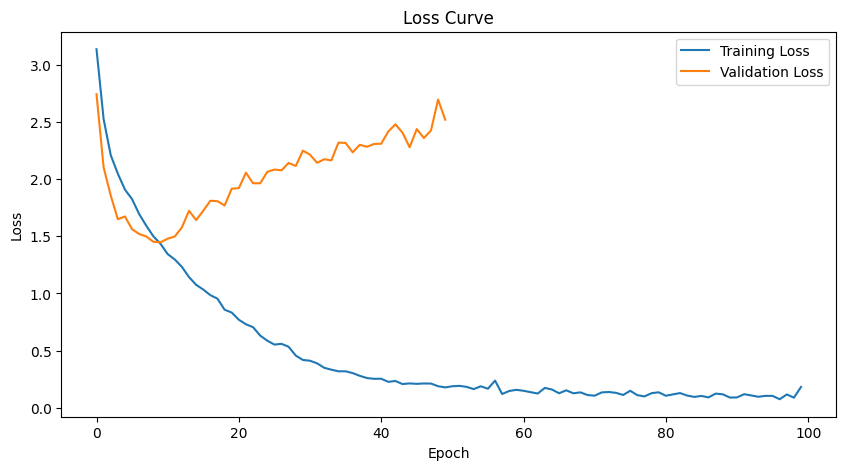

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.cuda.amp import GradScaler, autocast

class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=np.str_, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((img_size, img_size)),
            torchvision.transforms.ToTensor()
        ])

    def __getitem__(self, item):
        file_name = self.file_names[item]
        img_path = os.path.join(self.root_path, file_name)
        img = Image.open(img_path).convert("RGB")  # Ensure 3-channel consistency
        label = self.labels[item]

        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


class ClsTransformer(nn.Module):
    def __init__(self, in_channels, embedding_dim, patch_size, num_layers, num_heads,
                 img_size=224, num_classes=30):
        super(ClsTransformer, self).__init__()
        self.patch_embedding = nn.Conv2d(in_channels, embedding_dim, patch_size, patch_size)
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        num_token = (img_size // patch_size) * (img_size // patch_size) + 1
        self.pos_embedding = nn.Parameter(torch.randn(1, num_token, embedding_dim), requires_grad=False)
        self.model = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True),
            num_layers=num_layers
        )
        self.pred_fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        B, C, H, W = x.shape
        x = x.flatten(2).permute(0, 2, 1)  # Flatten and transpose
        cls_token = self.cls_embedding.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim=1) + self.pos_embedding
        x = self.model(x)
        cls_token = x[:, 0]
        logits = self.pred_fc(cls_token)
        return logits


if __name__ == '__main__':
    root_path = r'/content/drive/MyDrive/AID/data'
    batch_size = 16
    lr = 0.000107003612245976
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ClsTransformer(in_channels=3, embedding_dim=224, patch_size=24, num_layers=3, num_heads=2).to(device)

    train_dataset = ClsDataset(root_path, r'/content/drive/MyDrive/AID/train_data_list.txt')
    valid_dataset = ClsDataset(root_path, r'/content/drive/MyDrive/AID/val_data_list.txt')

    train_dataloader = data_utils.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_dataloader = data_utils.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=4, pin_memory=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scaler = GradScaler()  # For mixed precision training
    best_acc = 0

    # Variables to store loss values
    train_losses = []
    valid_losses = []

    for epoch in range(100):
        model.train()
        epoch_train_loss = 0.0  # Accumulate training loss
        for train_img, train_label in train_dataloader:
            train_img, train_label = train_img.to(device), train_label.to(device)

            optimizer.zero_grad()
            with autocast():  # Mixed precision
                logits = model(train_img)
                loss = criterion(logits, train_label)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_dataloader))  # Average training loss
        if epoch % 2 == 0:
            model.eval()
            all_labels, all_preds = [], []
            epoch_valid_loss = 0.0  # Accumulate validation loss
            with torch.no_grad():
                for valid_img, valid_label in valid_dataloader:
                    valid_img, valid_label = valid_img.to(device), valid_label.to(device)
                    with autocast():
                        logits = model(valid_img)
                        preds = torch.argmax(logits, dim=1)
                    valid_loss = criterion(logits, valid_label)
                    all_labels.extend(valid_label.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())
                    epoch_valid_loss += valid_loss.item()
            valid_losses.append(epoch_valid_loss / len(valid_dataloader))  # Average validation loss

            acc = accuracy_score(all_labels, all_preds)
            print(f'Epoch {epoch}, Validation Accuracy: {acc:.4f}')

            # Save the model if it has the best accuracy so far
            if acc > best_acc:
                best_acc = acc
                state_dict = model.state_dict()
                torch.save(state_dict, r'/content/drive/MyDrive/AID/ViT_best.pth')
                print(f"Best model saved with accuracy: {best_acc:.4f}")
    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()


ViT model evaluation

<ipython-input-11-70991b6b8a83>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Test Accuracy: 0.5799
Test Precision: 0.5929
Test Recall: 0.5799
Test F1 Score: 0.5767


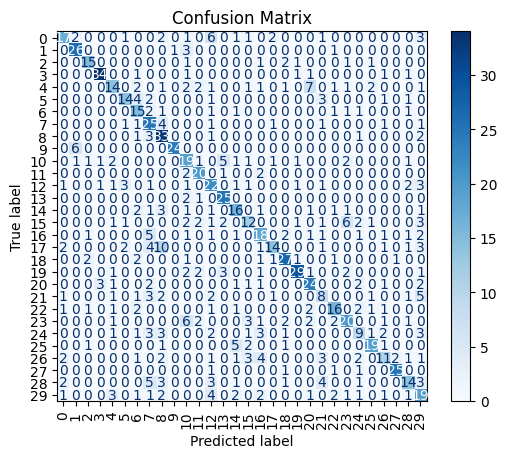

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt


# Dataset class
class ClsDataset(data_utils.Dataset):
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path
        self.transforms = Compose([Resize((img_size, img_size)), ToTensor()])

    def __getitem__(self, item):
        file_name = self.file_names[item]
        data_file = os.path.join(self.root_path, file_name)
        img = Image.open(data_file).convert('RGB')
        label = self.labels[item]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


# ViTransformer class
class ClsTransformer(nn.Module):
    def __init__(self, in_channels, embedding_dim, patch_size, num_layers, num_heads,
                 img_size=224, num_classes=30):
        super(ClsTransformer, self).__init__()
        self.patch_embedding = nn.Conv2d(in_channels, embedding_dim, patch_size, patch_size)
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        num_token = (img_size // patch_size) * (img_size // patch_size) + 1
        self.pos_embedding = nn.Parameter(torch.randn(1, num_token, embedding_dim), requires_grad=False)
        self.model = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True),
            num_layers=num_layers
        )
        self.pred_fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        B, C, H, W = x.shape
        x = x.flatten(2).permute(0, 2, 1)  # Flatten and transpose
        cls_token = self.cls_embedding.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim=1) + self.pos_embedding
        x = self.model(x)
        cls_token = x[:, 0]
        logits = self.pred_fc(cls_token)
        return logits


if __name__ == '__main__':
    # Load the model architecture
    model = ClsTransformer(in_channels=3, embedding_dim=224, patch_size=24, num_layers=3, num_heads=2, num_classes=30)
    # Load the checkpoint
    checkpoint_path = r'/content/drive/MyDrive/AID/ViT_best.pth'
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Prepare the test dataset and dataloader
    test_dataset = ClsDataset(
        root_path=r'/content/drive/MyDrive/AID/data',
        data_list_file=r'/content/drive/MyDrive/AID/test_data_list.txt',
    )
    test_dataloader = data_utils.DataLoader(
        test_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count()
    )

    # Initialize metrics tracking
    label_list = []
    pred_list = []

    # Inference loop
    for data in test_dataloader:
        test_img, test_label = data
        test_img = test_img.to(device)
        test_label = test_label.to(device)

        # Forward pass
        with torch.no_grad():
            test_logits = model(test_img)
            test_pred = torch.argmax(test_logits, dim=1)

        # Append results for evaluation
        label_list.append(test_label.cpu().numpy())
        pred_list.append(test_pred.cpu().numpy())

    # Concatenate all predictions and labels
    label_list = np.concatenate(label_list)
    pred_list = np.concatenate(pred_list)

    # Calculate metrics
    test_acc = accuracy_score(label_list, pred_list)
    test_precision = precision_score(label_list, pred_list, average='weighted')
    test_recall = recall_score(label_list, pred_list, average='weighted')
    test_f1 = f1_score(label_list, pred_list, average='weighted')

    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')

    # Generate and display the confusion matrix
    cm = confusion_matrix(label_list, pred_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_list))
    disp.plot(cmap='Blues', xticks_rotation='vertical')

    plt.title('Confusion Matrix')
    plt.show()


SVM optuna

In [ ]:
%pip install optuna

import os
import numpy as np
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor
import torchvision.models as models
import torch
#import pickle  # For saving the trained SVM model
import optuna


# Dataset class
class ClsDataset:
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path
        self.transforms = Compose([Resize((img_size, img_size)), ToTensor()])

    def __getitem__(self, index):
        file_name = self.file_names[index]
        img_path = os.path.join(self.root_path, file_name)
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


def extract_features(dataloader, model, device):
    """Extracts features from images using a pretrained CNN."""
    features, labels = [], []
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())

    return np.vstack(features), np.hstack(labels)


def objective(trial):
    """Objective function for Optuna to tune SVM hyperparameters."""
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)

    # SVM model pipeline
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=C, gamma=gamma, probability=True))
    svm_model.fit(train_features, train_labels)

    # Validation predictions and accuracy
    valid_preds = svm_model.predict(valid_features)
    valid_accuracy = accuracy_score(valid_labels, valid_preds)
    return valid_accuracy


if __name__ == "__main__":
    # Paths
    root_path = '/content/drive/MyDrive/AID/data'
    train_list = '/content/drive/MyDrive/AID/train_data_list.txt'
    valid_list = '/content/drive/MyDrive/AID/val_data_list.txt'

    # Parameters
    batch_size = 32
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Prepare datasets
    train_dataset = ClsDataset(root_path, train_list, img_size=224)
    valid_dataset = ClsDataset(root_path, valid_list, img_size=224)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Pretrained CNN for feature extraction
    pretrained_model = models.resnet50(pretrained=True)
    pretrained_model.fc = torch.nn.Identity()  # Remove the classification head
    pretrained_model = pretrained_model.to(device)

    print("Extracting features for training set...")
    train_features, train_labels = extract_features(train_dataloader, pretrained_model, device)
    print("Extracting features for validation set...")
    valid_features, valid_labels = extract_features(valid_dataloader, pretrained_model, device)

    # Optuna study
    print("Starting hyperparameter tuning with Optuna...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Best parameters and evaluation
    print(f"Best parameters: {study.best_params}")
    best_svm_model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', C=study.best_params['C'], gamma=study.best_params['gamma'], probability=True)
    )
    best_svm_model.fit(train_features, train_labels)
    valid_preds = best_svm_model.predict(valid_features)
    best_valid_accuracy = accuracy_score(valid_labels, valid_preds)
    print(f"Best Validation Accuracy: {best_valid_accuracy:.4f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


Extracting features for training set...
Extracting features for validation set...


[I 2024-11-30 08:23:08,665] A new study created in memory with name: no-name-e11c3e13-ce43-44c4-b09a-11a197950e82


Starting hyperparameter tuning with Optuna...


<ipython-input-13-228fa3c99b1f>:56: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
<ipython-input-13-228fa3c99b1f>:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
[I 2024-11-30 08:30:34,733] Trial 0 finished with value: 0.3915 and parameters: {'C': 19.61263619649709, 'gamma': 0.00333975691156459}. Best is trial 0 with value: 0.3915.
<ipython-input-13-228fa3c99b1f>:56: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  

Best parameters: {'C': 38.14955261877849, 'gamma': 0.0003631815201548182}
Best Validation Accuracy: 0.8830


SVM

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor
import torchvision.models as models
import torch
import pickle  # For saving the trained SVM model

# Dataset class
class ClsDataset:
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path
        self.transforms = Compose([Resize((img_size, img_size)), ToTensor()])

    def __getitem__(self, index):
        file_name = self.file_names[index]
        img_path = os.path.join(self.root_path, file_name)
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


def extract_features(dataloader, model, device):
    """Extracts features from images using a pretrained CNN."""
    features, labels = [], []
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device, non_blocking=True)  # Non-blocking transfers
            outputs = model(imgs)
            features.append(outputs.cpu().numpy())  # Batch-wise accumulation
            labels.append(lbls.numpy())

    return np.vstack(features), np.hstack(labels)


if __name__ == "__main__":
    # Paths
    root_path = '/content/drive/MyDrive/AID/data'
    train_list = '/content/drive/MyDrive/AID/train_data_list.txt'
    valid_list = '/content/drive/MyDrive/AID/val_data_list.txt'

    # Parameters
    batch_size = 32  # Increased batch size for better throughput
    num_workers = 4  # Parallel data loading
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Prepare datasets
    train_dataset = ClsDataset(root_path, train_list, img_size=224)
    valid_dataset = ClsDataset(root_path, valid_list, img_size=224)

    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    valid_dataloader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )

    # Pretrained CNN for feature extraction
    pretrained_model = models.resnet50(pretrained=True)
    pretrained_model.fc = torch.nn.Identity()  # Remove the classification head
    pretrained_model = pretrained_model.to(device)

    # Extract features (Precomputing features)
    train_features_path = "/content/drive/MyDrive/AID/train_features.npy"
    train_labels_path = "/content/drive/MyDrive/AID/train_labels.npy"
    valid_features_path = "/content/drive/MyDrive/AID/valid_features.npy"
    valid_labels_path = "/content/drive/MyDrive/AID/valid_labels.npy"

    if not (os.path.exists(train_features_path) and os.path.exists(valid_features_path)):
        print("Extracting features for training set...")
        train_features, train_labels = extract_features(train_dataloader, pretrained_model, device)
        np.save(train_features_path, train_features)
        np.save(train_labels_path, train_labels)

        print("Extracting features for validation set...")
        valid_features, valid_labels = extract_features(valid_dataloader, pretrained_model, device)
        np.save(valid_features_path, valid_features)
        np.save(valid_labels_path, valid_labels)
    else:
        print("Loading precomputed features...")
        train_features = np.load(train_features_path)
        train_labels = np.load(train_labels_path)
        valid_features = np.load(valid_features_path)
        valid_labels = np.load(valid_labels_path)

    # Train SVM
    print("Training SVM...")
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=38.14955261877849, gamma=0.0003631815201548182, probability=True))
    svm_model.fit(train_features, train_labels)

    # Evaluate SVM
    print("Evaluating SVM...")
    valid_preds = svm_model.predict(valid_features)
    valid_accuracy = accuracy_score(valid_labels, valid_preds)
    print(f"Validation Accuracy: {valid_accuracy:.4f}")

    # Save the trained SVM model
    with open('/content/drive/MyDrive/AID/svm_model.pkl', 'wb') as f:
        pickle.dump(svm_model, f)
    print("SVM model saved successfully.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features for training set...
Extracting features for validation set...
Training SVM...
Evaluating SVM...
Validation Accuracy: 0.8830
SVM model saved successfully.


SVM model evaluation

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features for the test set...
Evaluating SVM...
Test Accuracy: 0.8868
Test Precision: 0.8916
Test Recall: 0.8868
Test F1 Score: 0.8878


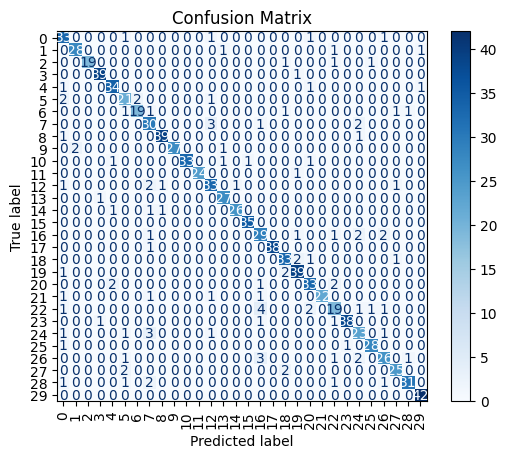

In [ ]:
import os
import numpy as np
import pickle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


# Dataset class (reuse from the provided code)
class ClsDataset:
    def __init__(self, root_path, data_list_file, img_size=224):
        self.file_names = np.loadtxt(data_list_file, dtype=str, usecols=0)
        self.labels = np.loadtxt(data_list_file, dtype=np.int64, usecols=1)
        self.root_path = root_path
        self.transforms = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        file_name = self.file_names[index]
        img_path = os.path.join(self.root_path, file_name)
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]
        img = self.transforms(img)
        return img, label

    def __len__(self):
        return len(self.file_names)


def extract_features(dataloader, model, device):
    """Extracts features from the test dataset using a pretrained CNN."""
    features, labels = [], []
    model.eval()

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())

    return np.vstack(features), np.hstack(labels)


if __name__ == "__main__":
    # Test dataset path
    test_dataset = ClsDataset(
        root_path=r'/content/drive/MyDrive/AID/data',
        data_list_file=r'/content/drive/MyDrive/AID/test_data_list.txt'
    )

    # Load test dataset
    batch_size = 32
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    test_features_path = "/content/drive/MyDrive/AID/test_features.npy"
    test_labels_path = "/content/drive/MyDrive/AID/test_labels.npy"
    # Load pretrained CNN model for feature extraction
    pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    pretrained_model.fc = torch.nn.Identity()  # Remove classification head
    pretrained_model = pretrained_model.to(device)

    # Extract test features
    print("Extracting features for the test set...")
    test_features, test_labels = extract_features(test_dataloader, pretrained_model, device)
    np.save(test_features_path, test_features)
    np.save(test_labels_path, test_labels)
    # Load trained SVM model
    with open('/content/drive/MyDrive/AID/svm_model.pkl', 'rb') as f:
        svm_model = pickle.load(f)

    # Predict using SVM
    print("Evaluating SVM...")
    test_preds = svm_model.predict(test_features)

    # Calculate metrics
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds, average='weighted')
    test_recall = recall_score(test_labels, test_preds, average='weighted')
    test_f1 = f1_score(test_labels, test_preds, average='weighted')

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


Random forest optuna

In [ ]:
%pip install optuna
import os
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pickle  # For saving the trained Random Forest model
import optuna  # Import Optuna

# Initialize a global variable for tracking the best model
best_rf_model = None  # Define it globally to avoid the NameError

# Objective function for Optuna
def objective(trial):
    global best_rf_model  # Ensure the function can access and modify the global variable

    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 200, step=50)
    max_depth = trial.suggest_int("max_depth", 10, 50, step=10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 4, step=1)

    # Load pre-extracted features
    train_features_path = "/content/drive/MyDrive/AID/train_features.npy"
    train_labels_path = "/content/drive/MyDrive/AID/train_labels.npy"
    valid_features_path = "/content/drive/MyDrive/AID/valid_features.npy"
    valid_labels_path = "/content/drive/MyDrive/AID/valid_labels.npy"

    train_features = np.load(train_features_path)
    train_labels = np.load(train_labels_path)
    valid_features = np.load(valid_features_path)
    valid_labels = np.load(valid_labels_path)

    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf_model.fit(train_features, train_labels)

    # Evaluate Random Forest
    valid_preds = rf_model.predict(valid_features)
    valid_accuracy = accuracy_score(valid_labels, valid_preds)

    # Save the best model during the trial
    if best_rf_model is None or valid_accuracy > getattr(best_rf_model, "best_accuracy", -1):
        rf_model.best_accuracy = valid_accuracy  # Attach accuracy to the model
        best_rf_model = rf_model

    return valid_accuracy  # Return accuracy to guide Optuna optimization


if __name__ == "__main__":
    # Optuna study
    study = optuna.create_study(direction="maximize")  # Maximizing accuracy
    study.optimize(objective, n_trials=20)  # Run 20 trials for hyperparameter tuning

    # Print the best hyperparameters and accuracy
    print("Best hyperparameters:", study.best_params)
    print("Best accuracy:", study.best_value)

    # Save the best trained RF model
    with open(r'/content/drive/MyDrive/AID/best_rf_model.pkl', 'wb') as f:
        pickle.dump(best_rf_model, f)  # Save the best_rf_model instead of svm_model
    print("RF model saved successfully.")


[I 2024-12-01 05:08:17,891] A new study created in memory with name: no-name-e0969e92-8d8b-4646-8967-a921d1f10781
[I 2024-12-01 05:09:26,038] Trial 0 finished with value: 0.795 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.795.
[I 2024-12-01 05:10:31,075] Trial 1 finished with value: 0.79 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.795.
[I 2024-12-01 05:11:24,024] Trial 2 finished with value: 0.768 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.795.
[I 2024-12-01 05:12:30,918] Trial 3 finished with value: 0.804 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.804.
[I 2024-12-01 05:13:14,020] Trial 4 finished with value: 0.7825 and parameters: {'n

Best hyperparameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3}
Best accuracy: 0.804
RF model saved successfully.


Random forest model evaluation

Evaluating Random Forest...
Test Accuracy: 0.7865
Test Precision: 0.7904
Test Recall: 0.7865
Test F1 Score: 0.7824


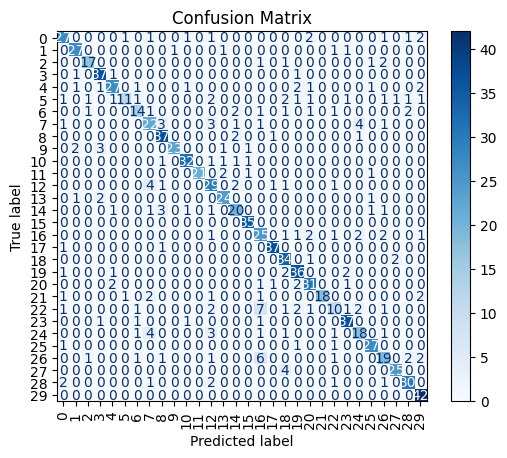

In [ ]:
import os
import numpy as np
import pickle
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load test label and test features
test_features_path = "/content/drive/MyDrive/AID/test_features.npy"
test_labels_path = "/content/drive/MyDrive/AID/test_labels.npy"
test_features = np.load(test_features_path)
test_labels = np.load(test_labels_path)
# Load trained Random Forest model
with open('/content/drive/MyDrive/AID/best_rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# Predict using Random Forest
print("Evaluating Random Forest...")
test_preds = rf_model.predict(test_features)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
